<a href="https://colab.research.google.com/github/rsmecking/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Ryan_Mecking_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [x] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [6]:
#  Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY 
# DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
df_sub = df[(df['SALE_PRICE'] >=  100000) & 
        (df['SALE_PRICE'] <= 2000000) &
        (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]
df_sub.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
120,3,OTHER,01 ONE FAMILY DWELLINGS,1,6806,72,NaN,A1,1747 EAST 23RD STREET,NaN,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,1,A1,1150000,01/02/2019
121,3,OTHER,01 ONE FAMILY DWELLINGS,1,6761,42,NaN,A1,1582 EAST 15TH STREET,NaN,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,1,A1,836500,01/02/2019
132,4,OTHER,01 ONE FAMILY DWELLINGS,1,7378,4,NaN,A1,201-08 50TH AVENUE,NaN,11364.0,1.0,0.0,1.0,"3,000",1396.0,1930.0,1,A1,955000,01/02/2019
137,4,OTHER,01 ONE FAMILY DWELLINGS,1,2882,16,NaN,A5,85-11 57 ROAD,NaN,11373.0,1.0,0.0,1.0,"1,800",1260.0,1935.0,1,A5,820000,01/02/2019
141,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,7407,50,NaN,A0,53-19 198TH STREET,NaN,11365.0,1.0,0.0,1.0,"4,000",1440.0,1945.0,1,A0,980000,01/02/2019


In [7]:
# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
df_sub['SALE_DATE'] = pd.to_datetime(df_sub['SALE_DATE'], infer_datetime_format=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
cutoff = pd.to_datetime('2019-03-31')
train = df_sub[df_sub.SALE_DATE < cutoff]
test  = df_sub[df_sub.SALE_DATE >= cutoff]

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'APARTMENT_NUMBER', 'EASE-MENT', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [11]:
# Do one-hot encoding of categorical features.
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
# X_test
X_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,1,1,0,4081,44,0,0,0,0,1,0,0,0,0,0,0,0,0,10306.0,1.0,0.0,1.0,921.0,1950.0,1,0,0,0,0,1,0,0,0,0,0,0
18130,0,0,0,1,0,1,0,0,0,0,0,1,1,0,2373,201,0,0,1,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,2128.0,1980.0,1,0,0,1,0,0,0,0,0,0,0,0
18132,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1132,42,0,1,0,0,0,0,0,0,0,0,0,0,0,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,0,1,0,0,0,0,0,0,0,0,0
18134,0,0,0,1,0,1,0,0,0,0,0,1,1,0,3395,37,0,0,0,0,1,0,0,0,0,0,0,0,0,10305.0,1.0,0.0,1.0,621.0,1930.0,1,0,0,0,0,1,0,0,0,0,0,0


In [0]:
# Do feature selection with `SelectKBest`.
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=15)

In [13]:
#Setting variable to transform and checking the shapes
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2517, 15), (647, 15))

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
#using Ryan Hurr's code to see what is the best amount of features to select
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
k_list = list(range(1, len(X_train.columns)+1))

for k in range(1, len(X_train.columns)+1):
  

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  mae_list.append(mae)

In [16]:
mae_list

[185788.22229822693,
 184747.87656952292,
 184747.87656952292,
 176119.34800560682,
 177178.27607188863,
 175312.6750649356,
 175816.60653532486,
 175616.4140670336,
 171119.28778904153,
 163299.20044346823,
 162946.03281948064,
 163802.3479941258,
 165474.5655989085,
 164719.4628401654,
 164720.39181292724,
 164464.62325474792,
 164464.62325476826,
 164272.2854991674,
 164272.28549913355,
 164271.53252040336,
 164271.53252042425,
 162020.26436712284,
 162020.26436711338,
 162020.2643671055,
 162020.26436709976,
 161757.97152600595,
 161642.0746892569,
 161576.75101763153,
 161534.82687021975,
 162601.15753127498,
 162650.38305588867,
 162132.08302485672,
 162109.667281592,
 162127.69023325073,
 162989.82282006962,
 162978.98936956938,
 163042.0023163498,
 162241.1213347493,
 162241.1213347516,
 162252.9779107303,
 162237.2319818219,
 162235.8082608526,
 162539.728458408,
 162539.72845840556,
 162538.75135239566,
 162552.43566460587,
 162539.43795884852]

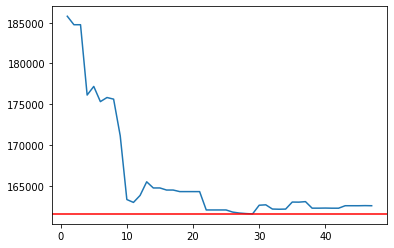

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_list, mae_list )
# plt.ax(0, min(mae_list), 'r--')
plt.axhline(y=min(mae_list), color='r', linestyle='-')
plt.show()

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
 
def ridge_regression(alpha):
    """
    Fit & plot a ridge regression model,
    with X_test_selected Quartet dataset III.
 
    alpha : positive float, regularization strength
    """
 
    # Plot data
    ax = X_test_selected.plot.scatter('x', 'y')
 
    # Fit linear model
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(X_test_selected[['x']], X_test_selected['y'])
 
    # Get linear equation
    m = ridge.coef_[0].round(2)
    b = ridge.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'
 
    # Get predictions
    X_test_selected['y_pred'] = ridge.predict(X_test_selected[['x']])
 
    # Plot predictions
    X_test_selected.plot('x', 'y_pred', ax=ax, title=title)
    plt.show()
    
for alpha in range(10):
    ridge_regression(alpha=alpha)

AttributeError: ignored